In [ ]:
from google.colab import output

!git clone https://github.com/MikhailovBair/EmbeddingComponents.git
!python -m pip install -e ./EmbeddingComponents

!python -m pip install shap datasets
!pip install --upgrade --no-cache-dir gdown
!gdown 1W3eo0VQXxcSjY8kx4IgHGlopd6OK69pp
!unzip probing.zip

!gdown 1PFSpW14aXO-sMNzT_jIjZPfNhk3u3ULD
!unzip probing_numbers.zip

output.clear()

In [ ]:
import gc
import random
import numpy as np
import pickle
from functools import partial
from datasets import load_from_disk
import torch
import torch.nn.functional as F
import shap
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from google.colab import drive

SEED = 8
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def prepare_embeds(task_embed):
    X = {'train':  torch.tensor(task_embed['train']['X']),
     'valid':  torch.tensor(task_embed['dev']['X']),
     'test':  torch.tensor(task_embed['test']['X'])}
    y = {'train':  torch.tensor(task_embed['train']['y']),
        'valid':  torch.tensor(task_embed['dev']['y']),
        'test':  torch.tensor(task_embed['test']['y'])}
    sc = StandardScaler()
    X['train'] = torch.tensor(sc.fit_transform(X['train']), dtype=torch.float)
    X['valid'] = torch.tensor(sc.transform(X['valid']), dtype=torch.float)
    X['test'] = torch.tensor(sc.transform(X['test']), dtype=torch.float)
    return X, y


def get_model_fvalues(task_name):
    task_embed = load_from_disk("{}.hf".format(task_name))
    labels = sorted(np.unique(task_embed['train']['y']))
    nclasses = len(dict(zip(labels, range(len(labels)))))
    X, y = prepare_embeds(task_embed)
    skb = SelectKBest(f_classif, k='all').fit(X['train'], y['train'])
    return skb.scores_

In [ ]:
transfer_tasks = [
    'Length',
    'Depth',
    'TopConstituents',
    'BigramShift',
    'Tense',
    'SubjNumber', 'ObjNumber',
    'OddManOut',
    'CoordinationInversion',
    'WordContent',
    ]

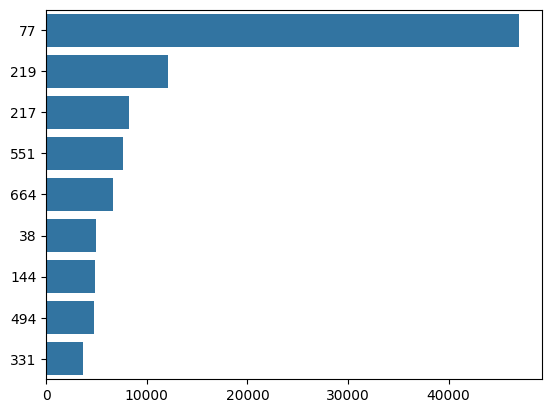

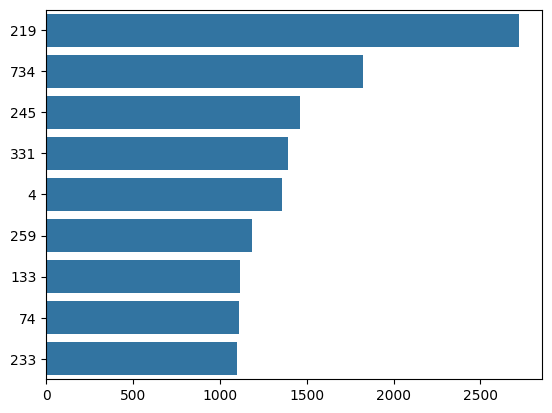

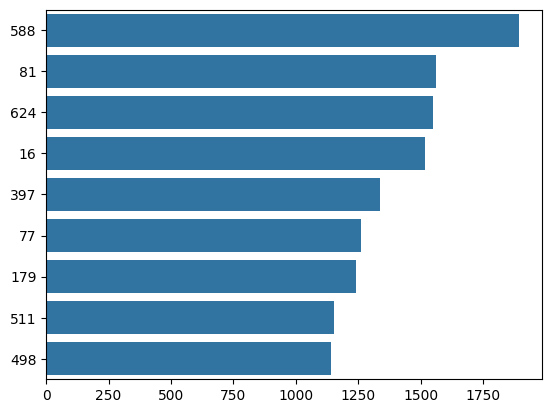

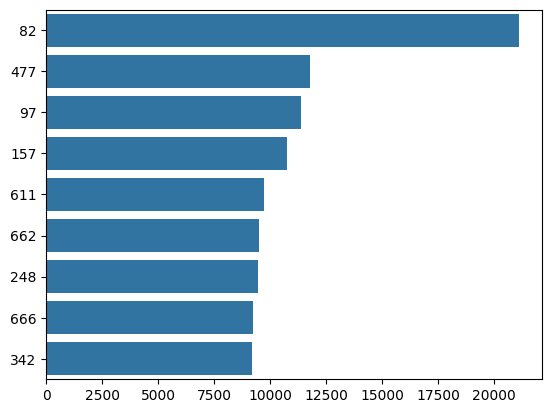

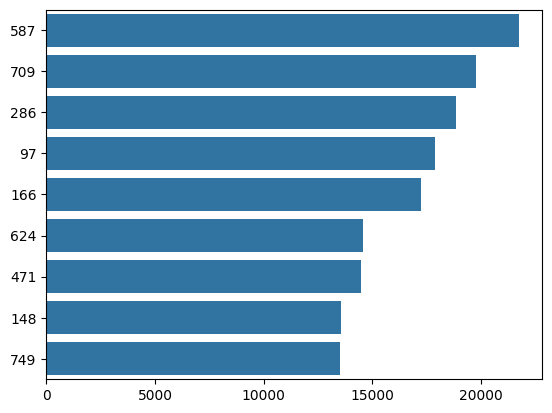

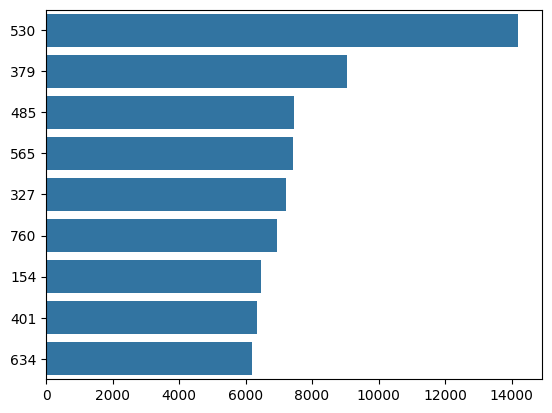

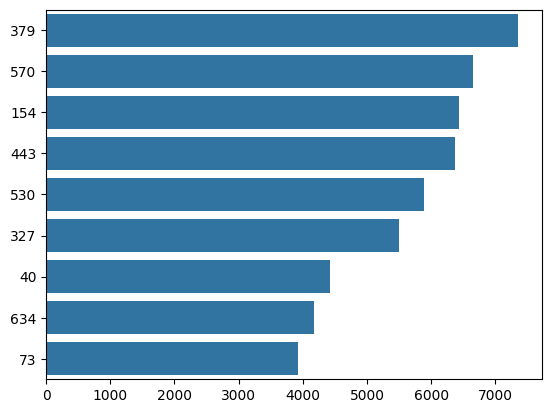

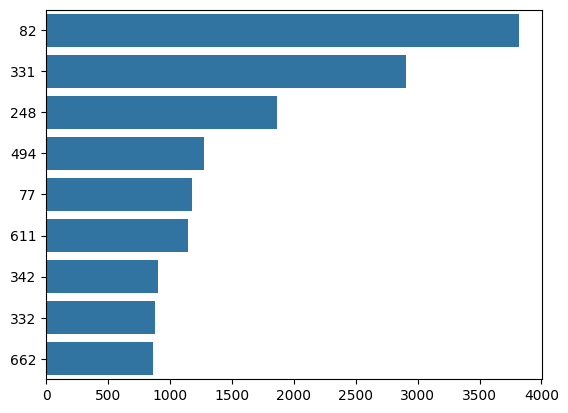

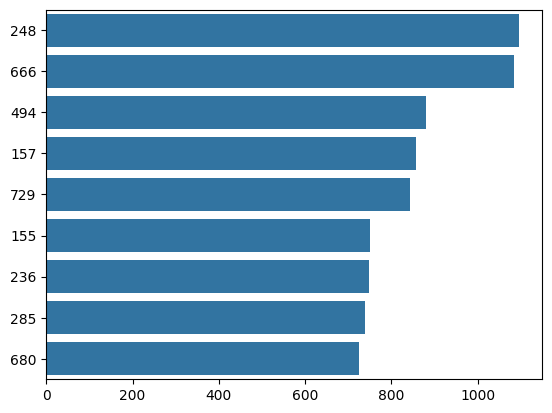

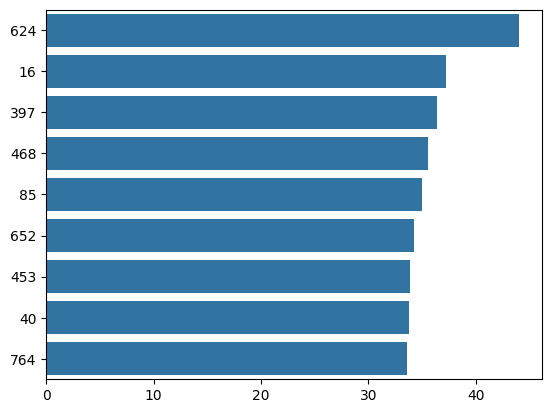

In [ ]:
fvalues = []
for transfer_task in transfer_tasks:
    fvalues.append(get_model_fvalues(transfer_task))
    best_names = np.array(fvalues[-1]).argsort()[:-10:-1]
    best_values = np.array(fvalues[-1])[best_names]
    best_names = [str(name) for name in best_names]
    sns.barplot(y=best_names, x=best_values, orient="y")
    plt.show()

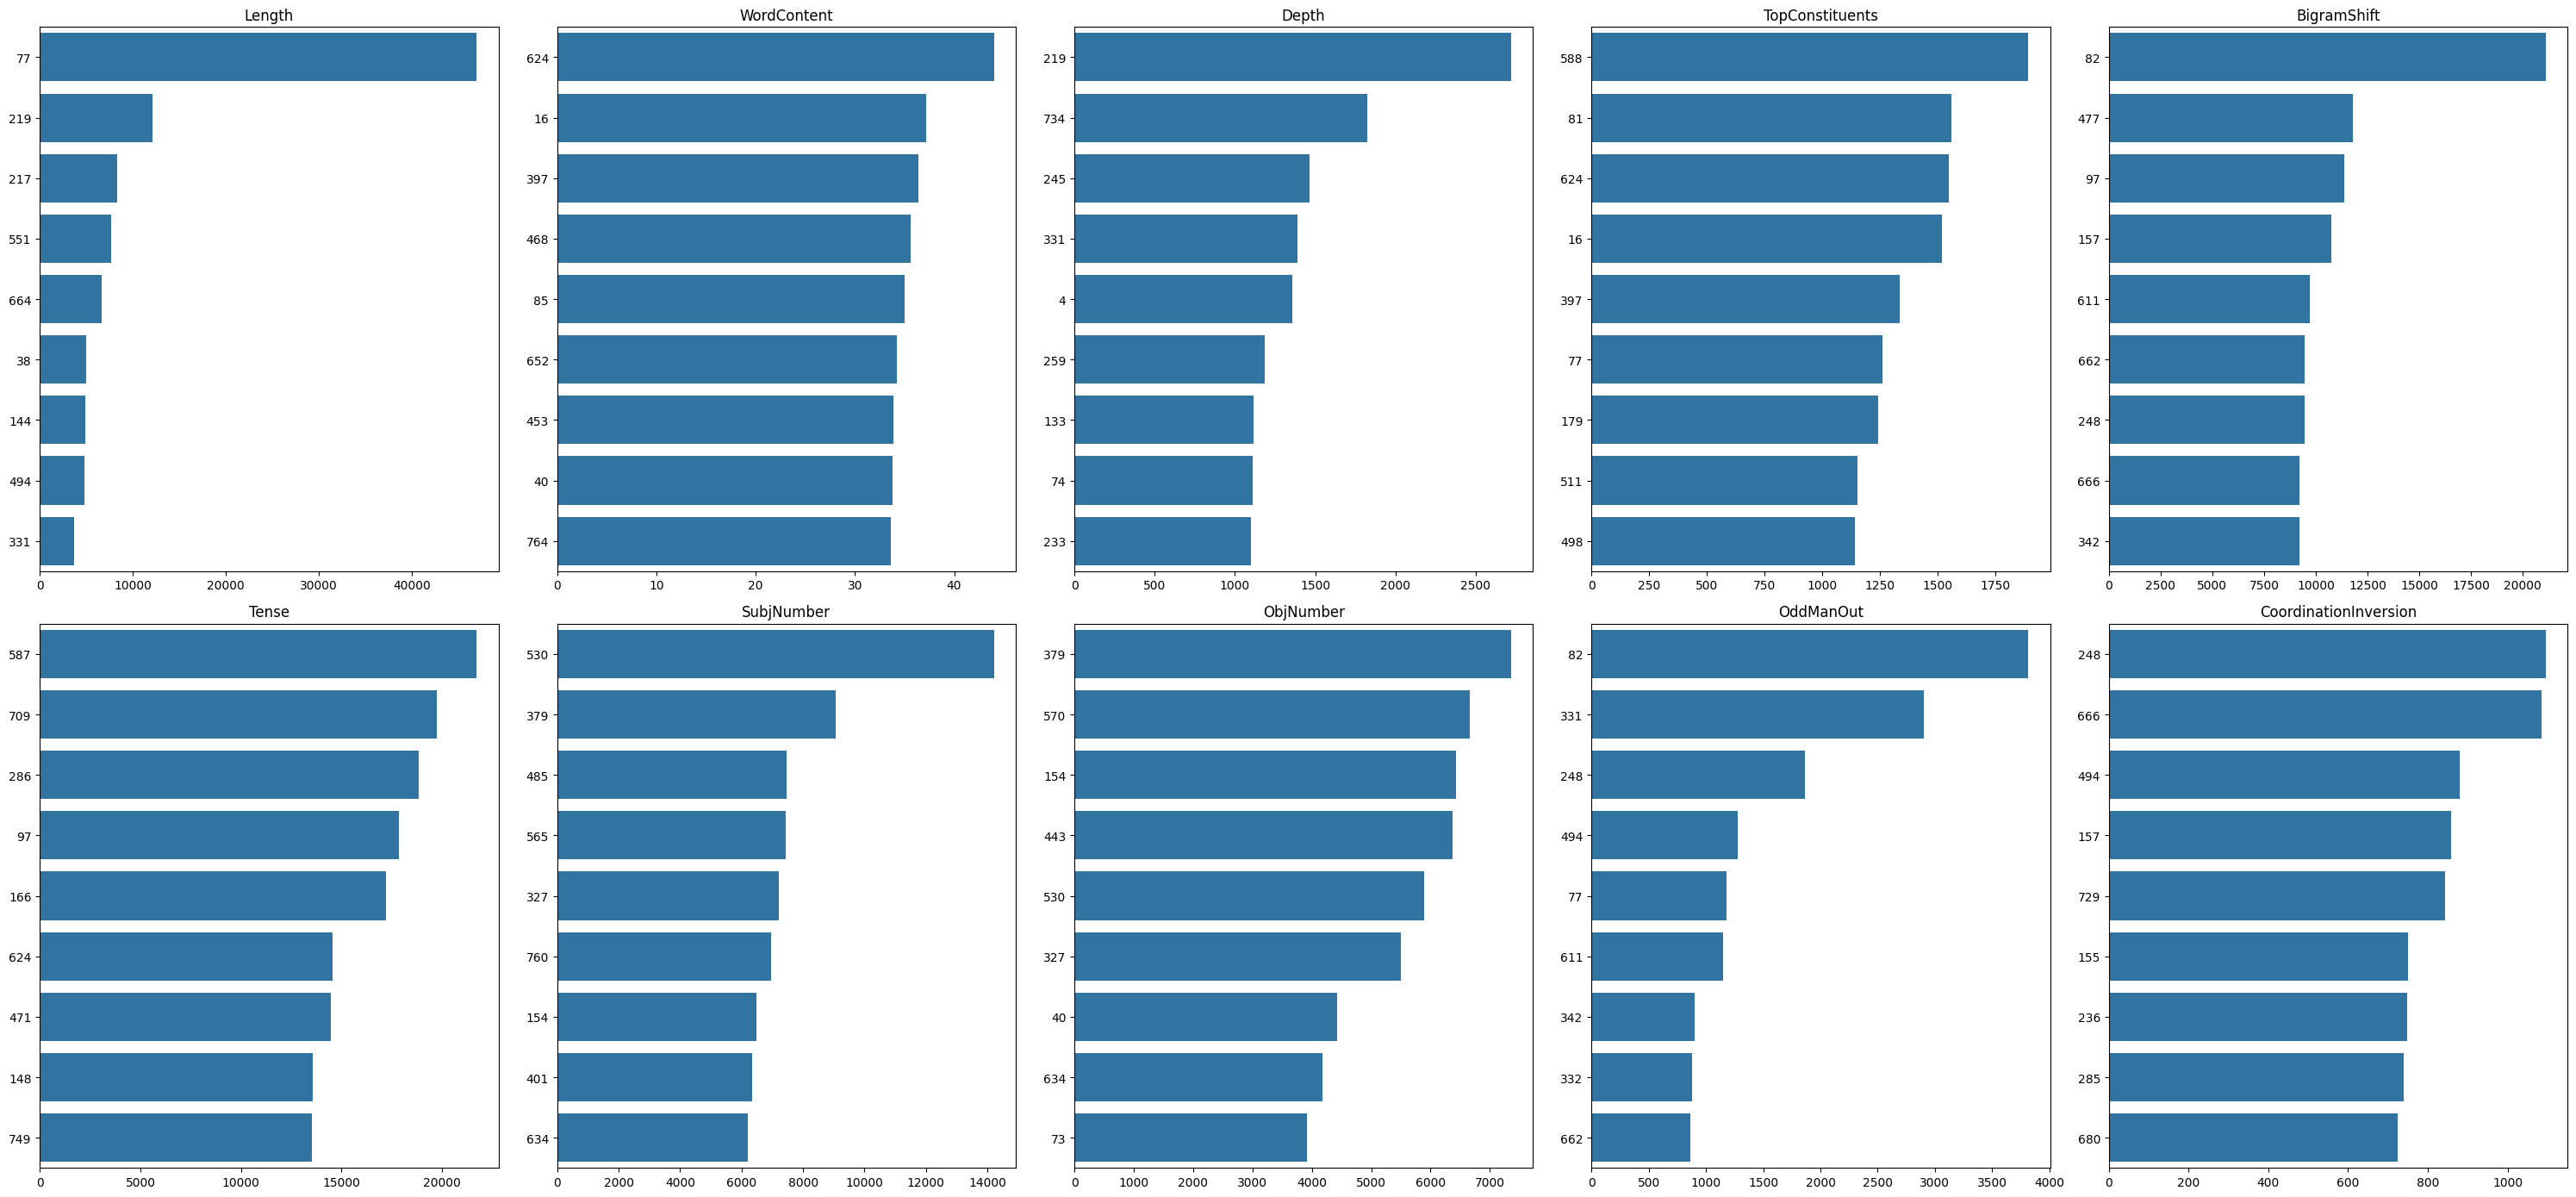

In [ ]:
plt.figure(figsize=(30, 14))
for i, weight in enumerate(fvalues):
    plt.subplot(2, 5, i + 1)
    best_names = np.array(weight).argsort()[:-10:-1]
    best_values = np.array(weight)[best_names]
    best_names = [str(name) for name in best_names]
    sns.barplot(y=best_names, x=best_values, orient="y")
    plt.title(transfer_tasks[i], )
plt.tight_layout()